In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# machine learning bit starts from here:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline


# building the model and crossvalidation pipeline:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.svm import SVR

# MOdel persistence:
import pickle

In [2]:
#file management
import os
#get current working directory
cwd = os.getcwd()

BASE_DIR = cwd
DATA_DIR = os.path.join(BASE_DIR, "data")
JUPYTER_DIR = os.path.join(BASE_DIR, "jupyter")


In [3]:
# import dataset from inside the data folder in the working directory:
#df = pd.read_csv("data\survey_results_public.csv")

#read survey results from csv file in the Data DIR
df = pd.read_csv(os.path.join(DATA_DIR, 'survey_results_public.csv'))

In [4]:
# check the data types of all the columns in df
print(df.dtypes)

ResponseId                        int64
MainBranch                       object
Employment                       object
Country                          object
US_State                         object
UK_Country                       object
EdLevel                          object
Age1stCode                       object
LearnCode                        object
YearsCode                        object
YearsCodePro                     object
DevType                          object
OrgSize                          object
Currency                         object
CompTotal                       float64
CompFreq                         object
LanguageHaveWorkedWith           object
LanguageWantToWorkWith           object
DatabaseHaveWorkedWith           object
DatabaseWantToWorkWith           object
PlatformHaveWorkedWith           object
PlatformWantToWorkWith           object
WebframeHaveWorkedWith           object
WebframeWantToWorkWith           object
MiscTechHaveWorkedWith           object


In [5]:
# select useful columns from the categorical and dataframe
df = df[
    [
        "Employment",
        "Country",
        "EdLevel",
        "YearsCode",
        "YearsCodePro",
        "DevType",
        "OrgSize",
        "Age",
        "ConvertedCompYearly",
    ]
]

# filter categorial colums to items where employment status is "employed full time"
df = df[df["Employment"] == "Employed full-time"]


#drop the employement column from df
df.drop(columns=["Employment"], inplace=True)

# count the number of countries in the 'Country" column
df["Country"].value_counts()


# if the count of each country is less than 500, rename the country to "Other"
for country in df["Country"].value_counts().index:
    if df["Country"].value_counts()[country] < 500:
        df["Country"].replace(country, "Other", inplace=True)

In [6]:
# count the number of countries in the 'Country" column
df["Country"].value_counts()

Other                                                   14101
United States of America                                11214
India                                                    6126
Germany                                                  3565
United Kingdom of Great Britain and Northern Ireland     3191
Canada                                                   1949
France                                                   1755
Brazil                                                   1595
Australia                                                1076
Spain                                                    1074
Netherlands                                              1070
Italy                                                    1033
Russian Federation                                       1003
Poland                                                    964
Sweden                                                    872
China                                                     650
Israel  

In [7]:
# remove all the rows with NA values from df
print(df.shape)
df = df.dropna()
print(df.shape)

(53584, 8)
(40006, 8)


In [8]:
# create a key value pair dictionary of the DevType column
dev_type_dict = {
    "front": "Front-end Developer",
    "back": "Back-end Developer",
    "scientist": "Data Scientist or ML Engr.",
    "full": "Full-stack Developer",
    "reliability": "SRE or Devops",
    "educator": "Academic Researcher",
    "research": "Academic Researcher",
    "student": "Academic Researcher",
    "manager": "Engineering Manager",
    "database": "Database Admin",
    "QA": "Software QA",
}


def clean_devtype(x):
    if "front" in x or "back" in x:
        return "Front-end Developer"
    if "scientist" in x:
        return "Data Scientist or ML Engr."
    if "full" in x:
        return "Full-stack Developer"
    if "reliability" in x:
        return "SRE or Devops"
    if "educator" in x or "research" in x or "student" in x:
        return "Academic Researcher"
    if "manager" in x:
        return "Engineering Manager"
    if "database" in x:
        return "Database Admin"
    if "QA" in x:
        return "Software QA"
    else:
        return "Other"


# apply the clean_devtype function to the DevType column
df["DevType"] = df["DevType"].apply(clean_devtype)

In [9]:
def clean_education(x):
    if "Bachelor’s degree" in x:
        return "Bachelors"
    if "professional degree" in x or "doctoral degree" in x:
        return "Post-grad"
    return "No bachelors"


df["EdLevel"] = df["EdLevel"].apply(clean_education)
df

,Country,EdLevel,YearsCode,YearsCodePro,DevType,OrgSize,Age,ConvertedCompYearly
9,Sweden,No bachelors,7,4,Data Scientist or ML Engr.,10 to 19 employees,25-34 years old,51552.0
11,Spain,Bachelors,12,5,Front-end Developer,10 to 19 employees,25-34 years old,46482.0
12,Germany,No bachelors,15,6,Front-end Developer,"1,000 to 4,999 employees",25-34 years old,77290.0
16,Turkey,Bachelors,6,2,Full-stack Developer,100 to 499 employees,25-34 years old,17748.0
17,Canada,Bachelors,9,6,Front-end Developer,500 to 999 employees,25-34 years old,46135.0
...,...,...,...,...,...,...,...,...
83432,Canada,Bachelors,5,Less than 1 year,Front-end Developer,"10,000 or more employees",18-24 years old,80169.0
83434,United States of America,Bachelors,6,5,Front-end Developer,20 to 99 employees,25-34 years old,160500.0
83436,United States of America,No bachelors,10,4,Data Scientist or ML Engr.,"10,000 or more employees",25-34 years old,90000.0
83437,Canada,Bachelors,5,3,Front-end Developer,20 to 99 employees,25-34 years old,816816.0


In [10]:
# get unique values of the 'OrgSize' column
df["OrgSize"].unique().astype(list)

array(['10 to 19 employees', '1,000 to 4,999 employees',
       '100 to 499 employees', '500 to 999 employees',
       '5,000 to 9,999 employees', '2 to 9 employees',
       '20 to 99 employees', '10,000 or more employees',
       'Just me - I am a freelancer, sole proprietor, etc.',
       'I don’t know'], dtype=object)

In [11]:
# clean up the orgz size column


def clean_orgsize(x):
    if "Just me" in x:
        return 1
    elif "10 to 19" in x:
        return 19
    elif "20 to 99" in x:
        return 99
    elif "100 to 499" in x:
        return 499 
    elif "1,000 to 4,999" in x:
        return 4999
    elif "5,000 to 9,999" in x:
        return 9999
    elif "10000 or more" in x:
        return 15000
    elif "know" in x:
        return np.nan
    else:
        return np.nan


df["OrgSize"] = df["OrgSize"].apply(clean_orgsize)
df

,Country,EdLevel,YearsCode,YearsCodePro,DevType,OrgSize,Age,ConvertedCompYearly
9,Sweden,No bachelors,7,4,Data Scientist or ML Engr.,19.0,25-34 years old,51552.0
11,Spain,Bachelors,12,5,Front-end Developer,19.0,25-34 years old,46482.0
12,Germany,No bachelors,15,6,Front-end Developer,4999.0,25-34 years old,77290.0
16,Turkey,Bachelors,6,2,Full-stack Developer,499.0,25-34 years old,17748.0
17,Canada,Bachelors,9,6,Front-end Developer,NaN,25-34 years old,46135.0
...,...,...,...,...,...,...,...,...
83432,Canada,Bachelors,5,Less than 1 year,Front-end Developer,NaN,18-24 years old,80169.0
83434,United States of America,Bachelors,6,5,Front-end Developer,99.0,25-34 years old,160500.0
83436,United States of America,No bachelors,10,4,Data Scientist or ML Engr.,NaN,25-34 years old,90000.0
83437,Canada,Bachelors,5,3,Front-end Developer,99.0,25-34 years old,816816.0


In [12]:
df.Age.unique()

array(['25-34 years old', '35-44 years old', '45-54 years old',
       '18-24 years old', '55-64 years old', '65 years or older',
       'Under 18 years old', 'Prefer not to say'], dtype=object)

In [13]:
# clean up the age column


def clean_age(x):
    if "Under 18 years old" in x:
        return 18
    elif "18" in x:
        return 18
    elif "25-34" in x:
        return 25
    elif "35" in x:
        return 35
    elif "45" in x:
        return 45
    elif "55" in x:
        return 55
    elif "65" in x:
        return 65
    else:
        return np.nan


# apply the clean_age function to the Age column
df["Age"] = df["Age"].apply(clean_age)
df

,Country,EdLevel,YearsCode,YearsCodePro,DevType,OrgSize,Age,ConvertedCompYearly
9,Sweden,No bachelors,7,4,Data Scientist or ML Engr.,19.0,25.0,51552.0
11,Spain,Bachelors,12,5,Front-end Developer,19.0,25.0,46482.0
12,Germany,No bachelors,15,6,Front-end Developer,4999.0,25.0,77290.0
16,Turkey,Bachelors,6,2,Full-stack Developer,499.0,25.0,17748.0
17,Canada,Bachelors,9,6,Front-end Developer,NaN,25.0,46135.0
...,...,...,...,...,...,...,...,...
83432,Canada,Bachelors,5,Less than 1 year,Front-end Developer,NaN,18.0,80169.0
83434,United States of America,Bachelors,6,5,Front-end Developer,99.0,25.0,160500.0
83436,United States of America,No bachelors,10,4,Data Scientist or ML Engr.,NaN,25.0,90000.0
83437,Canada,Bachelors,5,3,Front-end Developer,99.0,25.0,816816.0


In [14]:
#fill the orgsize column with the median of the orgsize column
df["OrgSize"].fillna(df["OrgSize"].median(), inplace=True)

# fill the age column with the median of the age column
df["Age"].fillna(df["Age"].median(), inplace=True)


In [15]:
def clean_years(x):
    if "More than 50" in str(x):
        return 60
    elif "Less than 1" in str(x):
        return 0
    else:
        return int(x)

# apply the clean_age function to the YearsCode column
df["YearsCodePro"] = df["YearsCodePro"].apply(clean_years)
df["YearsCode"] = df["YearsCode"].apply(clean_years)
df

,Country,EdLevel,YearsCode,YearsCodePro,DevType,OrgSize,Age,ConvertedCompYearly
9,Sweden,No bachelors,7,4,Data Scientist or ML Engr.,19.0,25.0,51552.0
11,Spain,Bachelors,12,5,Front-end Developer,19.0,25.0,46482.0
12,Germany,No bachelors,15,6,Front-end Developer,4999.0,25.0,77290.0
16,Turkey,Bachelors,6,2,Full-stack Developer,499.0,25.0,17748.0
17,Canada,Bachelors,9,6,Front-end Developer,499.0,25.0,46135.0
...,...,...,...,...,...,...,...,...
83432,Canada,Bachelors,5,0,Front-end Developer,499.0,18.0,80169.0
83434,United States of America,Bachelors,6,5,Front-end Developer,99.0,25.0,160500.0
83436,United States of America,No bachelors,10,4,Data Scientist or ML Engr.,499.0,25.0,90000.0
83437,Canada,Bachelors,5,3,Front-end Developer,99.0,25.0,816816.0


In [16]:
#drop na columns
df.dropna(inplace=True)

In [17]:
df.describe()
df.head()

#save df to the data folder in the working directory
df.to_csv(os.path.join(DATA_DIR, "survey_results_cleaned.csv"), index=False)
df.shape

(40006, 8)

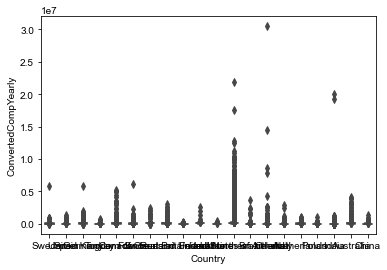

In [18]:
#construct boxplot of ConvertedCompYearly by Country

#construct the same boxplot using plotly
import plotly.graph_objects as go
import plotly.express as px

px.box(df, x="Country", y="ConvertedCompYearly", height=900, width=1000)

In [19]:
df.shape

(40006, 8)

In [20]:
#rename long countries to short countries
df.Country.replace('United States of America', 'USA', inplace=True)
df.Country.replace('United Kingdom of Great Britain and Northern Ireland', 'UK', inplace=True)
df.Country.replace('Russian Federation', 'Russia', inplace=True)
df.Country.replace('Republic of Korea', 'South Korea', inplace=True)
df.Country.replace('Iran, Islamic Republic of...', 'Iran', inplace=True)

<AxesSubplot:xlabel='Country', ylabel='ConvertedCompYearly'>

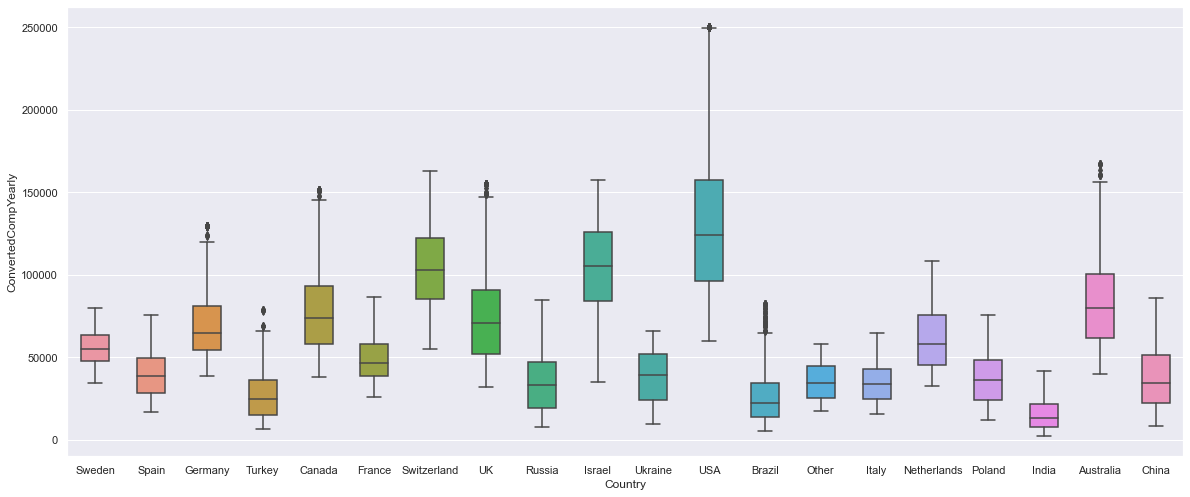

In [21]:
#for each country, need to remove the outliers using the upper bound and lower bound obtained from the boxplot

#get unique values of the 'Country' column
def get_upper_fences(df):
    countries = df["Country"].unique().astype(list)
    upper_fence = {}
    for country in countries:
        df_country = df[df["Country"] == country]
        #append upper fence to the dictionary
        upper_fence[country] = df_country["ConvertedCompYearly"].quantile(0.99)
    return (upper_fence)

def get_lower_fences(df):
    countries = df["Country"].unique().astype(list)
    lower_fence = {}
    for country in countries:
        df_country = df[df["Country"] == country]
        #append lower fence to the dictionary
        lower_fence[country] = df_country["ConvertedCompYearly"].quantile(0.01)
    return (lower_fence)



def remove_outliers_per_country(df):
    upper= get_upper_fences(df)
    lower = get_lower_fences(df)
    countries = df["Country"].unique().astype(list)
    new_df = []
    for country in countries:
        df_country = df[df["Country"] == country]
        
        #filter each df_country by the upper fence
        df_country = df_country[df_country["ConvertedCompYearly"] <= upper[country]]
        df_country = df_country[df_country["ConvertedCompYearly"] >= lower[country]]
        #add df_country to the new_df
        new_df.append(df_country)
    #merge all the dataframes into one
    new_df = pd.concat(new_df)
    return (new_df)



#apply this technique until the boxplot shows no outliers. I found that this technique particluarly well to clean the convertedcomp after up to 40 runs. 
i = 0
while i < 40:
    df = remove_outliers_per_country(df)
    i += 1

#Plot the boxplot again to see the outliers removed
sns.boxplot(x="Country", y="ConvertedCompYearly", data=df, width = 0.5)



In [22]:

# separete the target variable from the dataframe
y = df["ConvertedCompYearly"]
X = df.drop("ConvertedCompYearly", axis=1)

c:\Users\vcktor\Desktop\Projects\SalaryPrediction\ml\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

c:\Users\vcktor\Desktop\Projects\SalaryPrediction\ml\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

c:\Users\vcktor\Desktop\Projects\SalaryPrediction\ml\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histp

'for country in countries:\n    df_country = df[df["Country"] == country]\n    sns.histplot(df_country["ConvertedCompYearly"], bins=10, kde=False, color="red")\n    plt.title("Histogram of ConvertedCompYearly for " + country)\n    plt.show()'

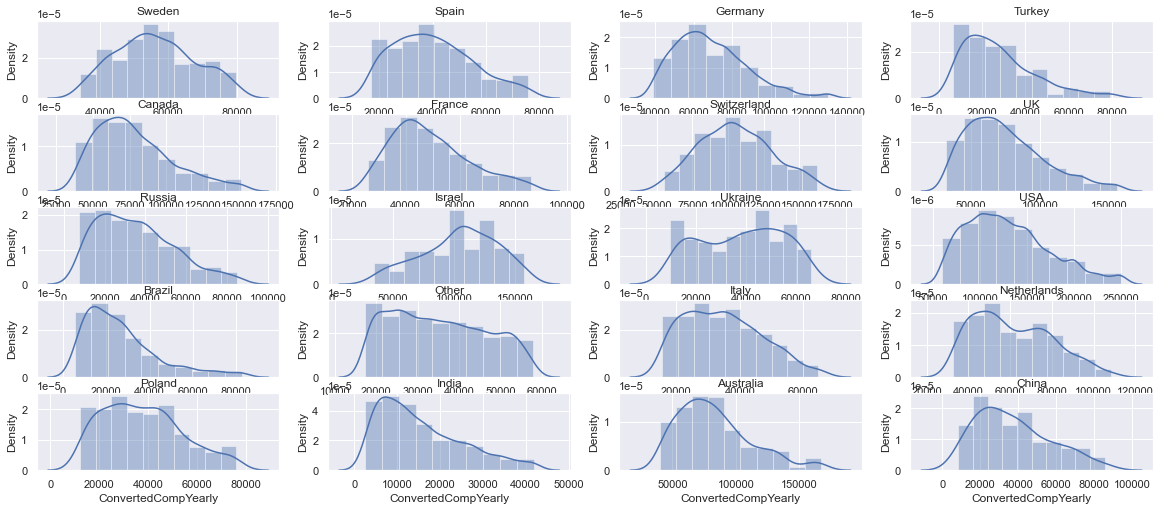

In [38]:
#for each country, plot the histogram of the ConvertedCompYearly column
countries = df["Country"].unique().astype(list)

#for each country, plot the histogram of the ConvertedCompYearly column in a 5*4 grid with space between the plots
for i, country in enumerate(countries):
    plt.subplot(5, 4, i + 1)
    df_country = df[df["Country"] == country]
    sns.distplot(df_country["ConvertedCompYearly"], bins=10)
    plt.title(country)

'''for country in countries:
    df_country = df[df["Country"] == country]
    sns.histplot(df_country["ConvertedCompYearly"], bins=10, kde=False, color="red")
    plt.title("Histogram of ConvertedCompYearly for " + country)
    plt.show()'''

In [24]:
#split into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=989)



#convert the y_data to a numpy array that can be used in the model
y_train = np.array(y_train)
y_test = np.array(y_test)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(24012, 7)
(6004, 7)
(24012,)
(6004,)


In [25]:
#make pipeline to encode the categorical variables and scale the numerical variables
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA



ct = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore', sparse = True), ['DevType', 'EdLevel', 'Country']),
    (StandardScaler(), ['Age', 'YearsCode', 'YearsCodePro', 'OrgSize'], PCA(n_components=0.85),['Age', 'YearsCode', 'YearsCodePro', 'OrgSize']),
    remainder='passthrough'
)

X_train = ct.fit_transform(X_train)
X_test = ct.fit_transform(X_test)

#

In [26]:
#reshape y_test and y_train to be 2D so that it can be scaled
y_test = y_test.reshape(-1, 1)
y_train = y_train.reshape(-1, 1)

#create scaler object to scale the y
scaler = StandardScaler()
y_train = scaler.fit_transform(y_train)

In [27]:

#import scikitlearn SVR
from sklearn.svm import SVR

modelsvr = SVR()
#gridsearch:
params =  {'kernel' : ['rbf'],
                    'C' : [1],
                    'degree' : [3],
                    'coef0' : [0, 0.01],
                    'gamma' : ['auto']}

modelsvr = SVR()
grid = GridSearchCV(modelsvr, param_grid = params, cv = 5,
                    scoring='neg_mean_squared_error')

grid.fit(X_train, np.ravel(y_train))

print(grid.best_params_)
print(grid.best_estimator_)


#create model from the gs object
final_model = SVR(**grid.best_params_)
final_model.fit(X_train, np.ravel(y_train))


{'C': 1, 'coef0': 0, 'degree': 3, 'gamma': 'auto', 'kernel': 'rbf'}
SVR(C=1, coef0=0, gamma='auto')


SVR(C=1, coef0=0, gamma='auto')

In [28]:

#make predictions
y_pred = final_model.predict(X_test)

#inverse transform the predictions
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))

In [29]:
#print(y_pred)


#this model is probably overfitting, so we need to use cross validation to see if we can do better
from sklearn.model_selection import cross_val_score
scores = cross_val_score(final_model, X_train, np.ravel(y_train), cv=5, )
val_scores = scores.mean()

print("Cross Validation Scores: ", scores)
print("Average Cross Validation Score: ", val_scores)


Cross Validation Scores:  [0.74479687 0.74433589 0.73193713 0.72850762 0.73599464]
Average Cross Validation Score:  0.7371144294849419


In [30]:
#evaluate model RMSE
#import skleran metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score



from sklearn.metrics import mean_squared_error
print(f'R2 Score: {r2_score(y_test, y_pred)}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}')
print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'Mean Absolute Error: {mean_absolute_error(y_test, y_pred)}')




R2 Score: 0.7428073522378603
RMSE: 24399.963201401177
MAE: 16656.652615249168
Mean Absolute Error: 16656.652615249168


In [31]:
#save y_test and y_pred to csv
y_test = pd.DataFrame(y_test)
y_pred = pd.DataFrame(y_pred)
merged = pd.concat([y_test, y_pred], axis=1)
merged.columns = ["y_test", "y_pred"]
merged.to_csv("data/predictions.csv")


In [32]:

#import xgb regressor
from xgboost import XGBRegressor


# create a pipeline for the one hot encoder and standard scaler
xgb = XGBRegressor()

#use gridsearch to find the best parameters for the xgb regressor
from sklearn.model_selection import GridSearchCV

grid =  GridSearchCV(estimator=xgb,
                     param_grid={"max_depth": [1,10,50,100],
                                 "min_child_weight": [1, 2],
                                 "gamma": [1, 10, 100],
                                 },
                     scoring="neg_mean_squared_error",
                     cv=3,
                     n_jobs=-1,
                     verbose=1)

grid.fit(X_train, np.ravel(y_train))

best_params = grid.best_params_
best_estimator = grid.best_estimator_

Fitting 3 folds for each of 24 candidates, totalling 72 fits


In [33]:
#final xgboost model

xgb_model = XGBRegressor(**best_params)
xgb_model.fit(X_train, y_train)

#test the model
y_pred = xgb_model.predict(X_test)


#de-standardize y_pred
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))


In [34]:

#model performance metrics

from sklearn.metrics import r2_score

#printr2
print(f'R2 Score: {r2_score(y_test, y_pred)}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}')
print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'Mean Absolute Error: {mean_absolute_error(y_test, y_pred)}')


#cross validation
from sklearn.model_selection import cross_val_score
scores = cross_val_score(xgb_model, X_train, np.ravel(y_train), cv=3)
val_scores = scores.mean()
print("Cross Validation Scores: ", val_scores)




R2 Score: 0.739712643935178
RMSE: 24546.32231618182
MAE: 17365.911846854702
Mean Absolute Error: 17365.911846854702
Cross Validation Scores:  0.7357238684505841


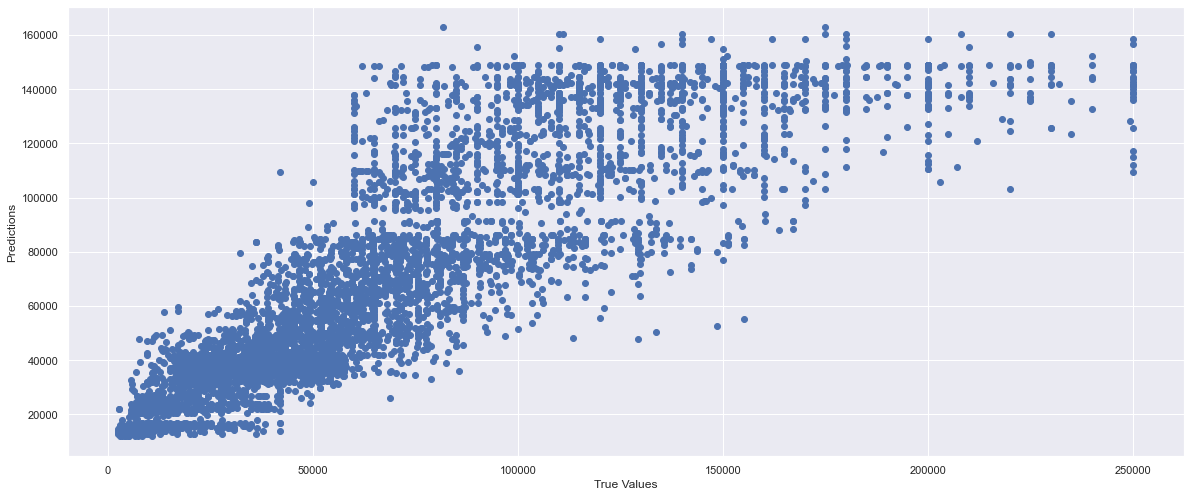

ValueError: x and y must be the same size

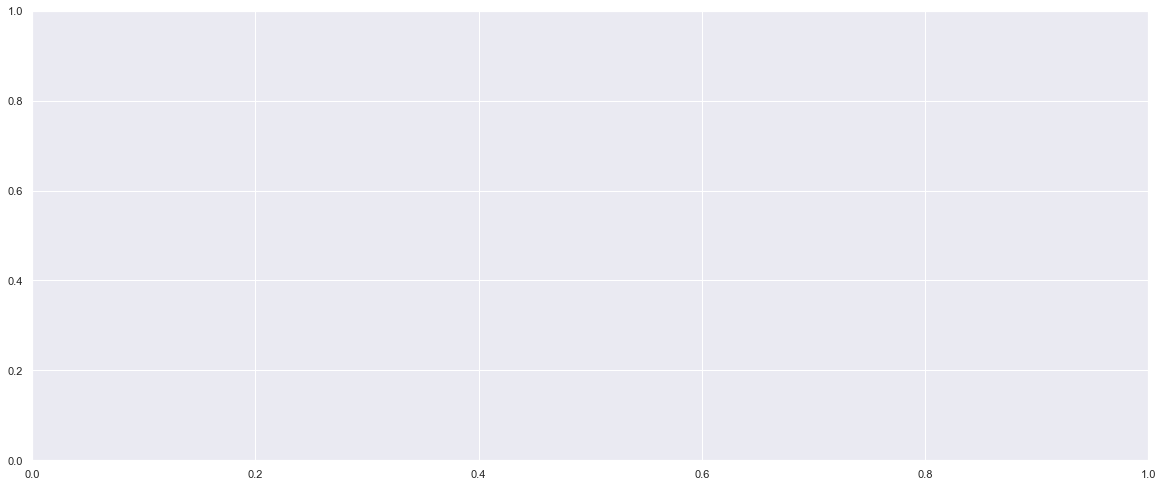

In [35]:

#plot test and predicted values with regression line
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()


#for each item in the test set, plot the true value and the predicted value
for i in range(len(y_test)):
    plt.scatter(y_test[i], y_pred[i])
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.show()
